## Lab 2: Dimensional modelling and ETL data processing F1 🏎️

**Team Members**:

- Yago Estévez Figueiras
- Andrea Real Blanco
- Francisco Manuel Vázquez Fernández

**Dataset**: [Formula 1 Pit Stops Analysis](https://www.kaggle.com/code/kevinkwan/formula-1-pit-stops-analysis/input)

---
This notebook implements the **Extract, Transform, Load (ETL)** pipeline to populate three star schemas for F1 data analysis: Qualifying, Pit Stops, and Race Results.

The code is structured into Helper Functions, Transformation Functions (Dimensions and Facts), and Loading Functions to support modularity and clarity.

**Table of Contents**:

1.  [Setup and Config](#1-setup-and-config)
2.  [Helper Functions](#2-helper-functions)
3.  [Data Inspection & Validation](#3-data-inspection-validation)
4.  [Transformation Functions](#4-transformation-functions)
5.  [ETL Loading & Execution](#5-etl-loading-execution)
    * [5.1 Connection & Dim Load](#51-connection-dim-load)
    * [5.2 Load Qualifying Schema](#52-load-qualifying-schema)
    * [5.3 Load Pit Stops Schema](#53-load-pit-stops-schema)
    * [5.4 Load Race Results Schema](#54-load-race-results-schema)

### 1. Setup and Config

This section loads dependencies and defines configuration parameters (`CONFIG` and `DATA_DIR`).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import *

In [2]:
# MySQL credentials configuration (Replace with actual credentials)
CONFIG = {
    'USERNAME': '',
    'PASSWORD': '',
    'HOST': '127.0.0.1',
    'PORT': '3306',
    'DB_NAME': 'project2_f1'
}

# Path to the folder that stores the csv files with / (or \) at the end
# Example: DATA_DIR = 'data/'
DATA_DIR = '' 

### 2. Helper Functions

These helper functions assist with checks, data inspection, and mandatory transformations:

- `connection(CONFIG)`: Establishes the database engine connection.
- `check_nulls(df)`: Implemented to validate dimension source data for missing values.
- `max_length(df)`: Calculates the maximum character length in each column. Used to inspect data content and determine appropriate VARCHAR sizes for the database schema.
- `q_to_ms(df)`: Performs the conversion of time strings (e.g., $Q1$ times) into integer milliseconds, standardizing the data for quantitative metrics.
- `racesDF()`: Loader for the races.csv file.

In [3]:
def check_nulls(df):
    """
    Checks a pandas DataFrame for any null (missing) values.

    Returns:
        list: A list of column labels that contain null values, 
              or None if no null values are found.
    """
    check = df.isnull().any()
    aux = check[check].index.tolist()
    
    if len(aux) == 0:
        print("Null values not found.")
        return
    else:
        print("Null values found and column labels stored in list.")
        print(df.isnull().sum())
        return aux
        
def max_length(df, labels=None):
    """
    Calculates and prints the maximum character length for string representations 
    of values in specified DataFrame columns.
    """
    if labels is None:
        labels = df.columns.tolist()

    for label in labels:
        column = df[label].astype(str)       
        maxval = column.str.len().max()
        print(f"Column: {label} | Max.char.length = {maxval}")
    return
    
def connection(CONFIG,df= None):
    """
    Establishes a connection to a MySQL database using the provided configuration.
    """
    engine = create_engine( f"mysql+pymysql://{CONFIG['USERNAME']}:{CONFIG['PASSWORD']}"
            f"@{CONFIG['HOST']}:{CONFIG['PORT']}/{CONFIG['DB_NAME']}")
    try:
        with engine.connect() as conn:
            print("Connection established succesfully!")
        return engine
    except Exception as e:
        print(f" Error: {e}")
    return 

def q_to_ms(df, columns):
    """
    Converts time-string columns (e.g., 'MM:SS.mmm' format) in a DataFrame to total 
    milliseconds (integer type) and replaces the original column(s). 
    Handles '\\N' as missing data.
    """
    for col in columns:
        new_col = f'{col}_ms'
        # Replace '\N' with NaN 
        df[col] = df[col].replace('\\N', np.nan)
        # Prepend '00:' to the time strings to convert to pandas Timedelta objects
        timedeltas = pd.to_timedelta('00:' + df[col], errors='coerce')
        # Calculate the total milliseconds of the Timedelta and fill NaNs with 0
        df[new_col] = (timedeltas.dt.total_seconds() * 1000).fillna(0).astype(int)
        # Remove original time-string column from the DataFrame
        df.drop(columns=[col], inplace=True)
    return df

def racesDF():
    """
    Reads the 'races.csv' file into a pandas DataFrame using specific column names 
    and treating '\\N' as a missing value indicator.
    """
    column_names = [
        'raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url',
        'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
        'quali_date', 'quali_time', 'sprint_date', 'sprint_time'
        ]
    races = pd.read_csv(
        f'{DATA_DIR}races.csv',
        header=0,                   
        names=column_names,         
        na_values='\\N'
        )
    return races

### 3. Data Inspection & Validation
We validate the integrity of the dimension source files and perform an initial analysis of key metric ranges

In [4]:
# Load raw dimension files for validation
raw_drivers = pd.read_csv(f"{DATA_DIR}drivers.csv", na_values="\\N")
raw_constructors = pd.read_csv(f"{DATA_DIR}constructors.csv", na_values="\\N")
raw_circuits = pd.read_csv(f"{DATA_DIR}circuits.csv", na_values="\\N")
raw_qualy = pd.read_csv(f"{DATA_DIR}qualifying.csv", na_values="\\N")
raw_pit = pd.read_csv(f"{DATA_DIR}pit_stops.csv", na_values="\\N")
raw_results = pd.read_csv(f"{DATA_DIR}results.csv", na_values="\\N")

print("--- Circuits Null Check ---")
check_nulls(raw_circuits);

#print("--- Drivers Null Check ---")
#check_nulls(raw_drivers);


#print("--- Constructors Null Check ---")
#check_nulls(raw_constructors);

#print("--- Qualifying Null Check ---")
#check_nulls(raw_qualy);

#print("--- Pit Stops Null Check ---")
#check_nulls(raw_pit);

#print("--- Results Null Check ---")
#check_nulls(raw_results);

--- Circuits Null Check ---
Null values found and column labels stored in list.
circuitId     0
circuitRef    0
name          0
location      0
country       0
lat           0
lng           0
alt           2
url           0
dtype: int64


In [5]:
print("Example: Max Lengths for VARCHAR Sizing")
print("-"*40)
max_length(raw_drivers, ['driverRef', 'forename', 'surname', 'nationality'])

Example: Max Lengths for VARCHAR Sizing
----------------------------------------
Column: driverRef | Max.char.length = 18
Column: forename | Max.char.length = 17
Column: surname | Max.char.length = 23
Column: nationality | Max.char.length = 17



--- Metric Range Analysis (Race Points) ---
Maximum Points Awarded in a Race: 50.0
Minimum Points Awarded (if > 0): 0.5


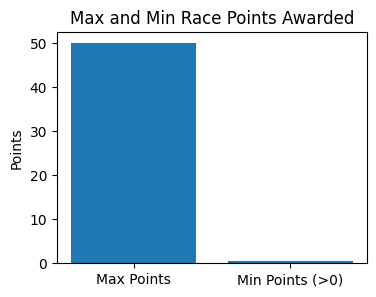

In [6]:
points_series = raw_results['points'].replace('\\N', np.nan).fillna(0).astype(float)

max_points = points_series.max()
min_points = points_series[points_series > 0].min() # Min points awarded

print(f"\n--- Metric Range Analysis (Race Points) ---")
print(f"Maximum Points Awarded in a Race: {max_points}")
print(f"Minimum Points Awarded (if > 0): {min_points}")

# Optional: A simple bar plot addressing the feedback to include a graph
plt.figure(figsize=(4, 3))
plt.bar(['Max Points', 'Min Points (>0)'], [max_points, min_points])
plt.title('Max and Min Race Points Awarded')
plt.ylabel('Points')
plt.show()


--- Graphical Analysis: Performance Metric Extremes ---


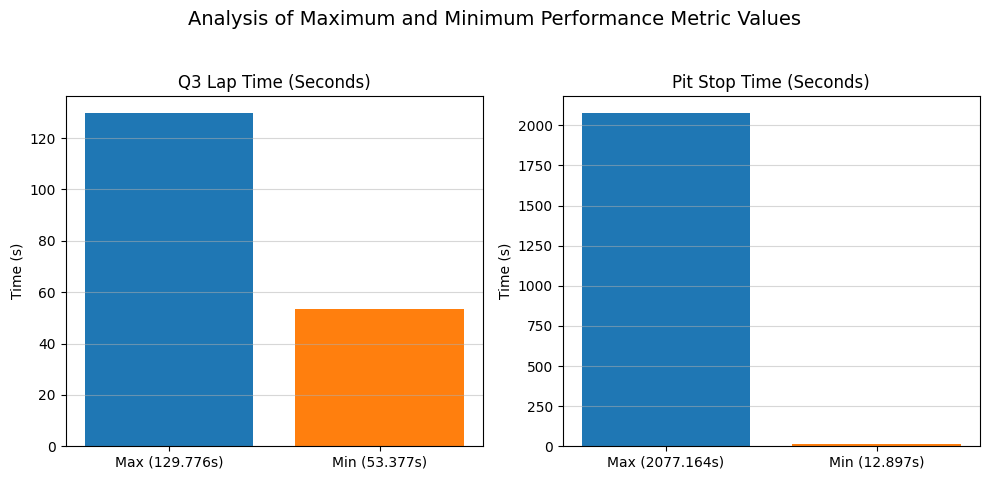


Q3 Time Range: The fastest Q3 lap recorded is 53377ms (53.377s) and the slowest is 129776ms.
Pit Stop Time Range: Pit times range from 12897ms (12.897s) to 2077164ms.


In [7]:
# --- Graph 1: Qualifying Time Extremes ---

qualy_temp = pd.read_csv(f"{DATA_DIR}qualifying.csv")[['q3']].copy()

qualy_ms_df = q_to_ms(qualy_temp, ['q3'])
q3_ms = qualy_ms_df['q3_ms']

# Find min/max values
max_q3 = q3_ms.max()
min_q3 = q3_ms[q3_ms > 0].min()

# --- Graph 2: Pit Stop Time Extremes ---

pit_temp = pd.read_csv(f"{DATA_DIR}pit_stops.csv")[['milliseconds']].copy()
pit_time_ms = pit_temp['milliseconds'].replace('\\N', np.nan).fillna(0).astype(int)

# Find min/max values
max_pit = pit_time_ms.max()
min_pit = pit_time_ms[pit_time_ms > 0].min()


# --- Results ---
print("\n--- Graphical Analysis: Performance Metric Extremes ---")

# Two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Analysis of Maximum and Minimum Performance Metric Values', fontsize=14)

# Plot 1: Qualifying Time (Q3)
q3_data = [max_q3 / 1000, min_q3 / 1000] # Convert back to seconds
q3_labels = [f"Max ({q3_data[0]:.3f}s)", f"Min ({q3_data[1]:.3f}s)"]

axes[0].bar(q3_labels, q3_data, color=['#1f77b4', '#ff7f0e'])
axes[0].set_title('Q3 Lap Time (Seconds)')
axes[0].set_ylabel('Time (s)')
axes[0].grid(axis='y', alpha=0.5)

# Plot 2: Pit Stop Time
pit_data = [max_pit / 1000, min_pit / 1000] # Convert back to seconds
pit_labels = [f"Max ({pit_data[0]:.3f}s)", f"Min ({pit_data[1]:.3f}s)"]

axes[1].bar(pit_labels, pit_data, color=['#1f77b4', '#ff7f0e'])
axes[1].set_title('Pit Stop Time (Seconds)')
axes[1].set_ylabel('Time (s)')
axes[1].grid(axis='y', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap
plt.show()

print(f"\nQ3 Time Range: The fastest Q3 lap recorded is {min_q3}ms ({min_q3/1000:.3f}s) and the slowest is {max_q3}ms.")
print(f"Pit Stop Time Range: Pit times range from {min_pit}ms ({min_pit/1000:.3f}s) to {max_pit}ms.")

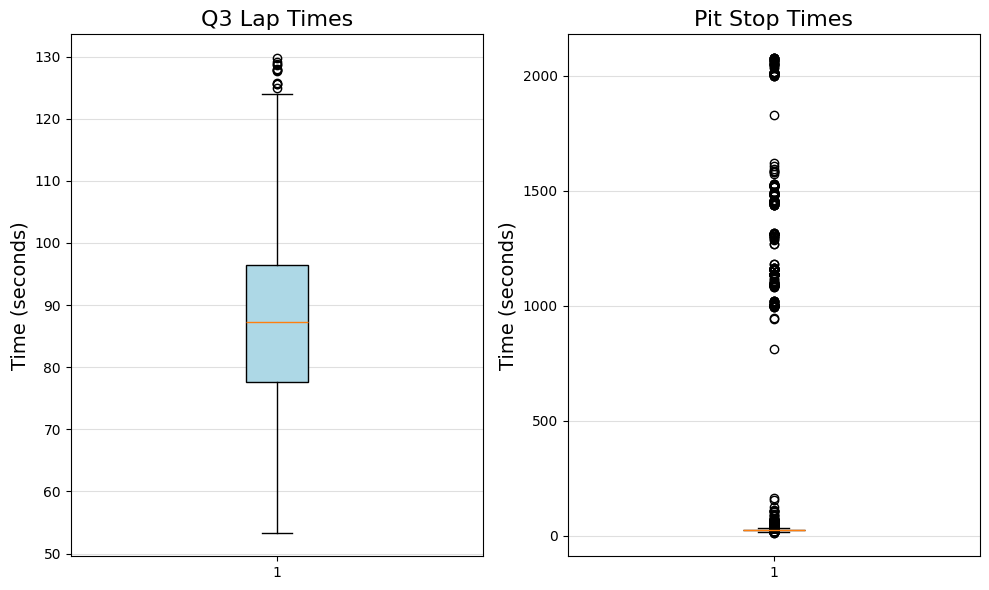

In [8]:
qualy_temp = pd.read_csv(f"{DATA_DIR}qualifying.csv")[['q3']].copy()
qualy_ms_df = q_to_ms(qualy_temp, ['q3'])
q3_ms = qualy_ms_df['q3_ms']
q3_ms = q3_ms[q3_ms > 0]  # exclude invalid times

pit_temp = pd.read_csv(f"{DATA_DIR}pit_stops.csv")[['milliseconds']].copy()
pit_time_ms = pit_temp['milliseconds'].replace('\\N', np.nan).fillna(0).astype(int)
pit_time_ms = pit_time_ms[pit_time_ms > 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
#Q3 Lap Times
axes[0].boxplot(q3_ms / 1000, patch_artist=True, boxprops=dict(facecolor='lightblue'))
axes[0].set_title('Q3 Lap Times', fontsize=16)
axes[0].set_ylabel('Time (seconds)', fontsize=14)
axes[0].grid(axis='y', alpha=0.4)

# Pit Stop Times
axes[1].boxplot(pit_time_ms / 1000, patch_artist=True, boxprops=dict(facecolor='lightcoral'))
axes[1].set_title('Pit Stop Times', fontsize=16)
axes[1].set_ylabel('Time (seconds)', fontsize=14)
axes[1].grid(axis='y', alpha=0.4)

plt.tight_layout()
plt.show()

### 4. Transformation Functions

The functions below implement the core transformation logic, creating the Dimensional tables and the Fact tables for the three star schemas.

- **Dimension tables**: `dim_driver`, `dim_constructor`, `dim_circuit`, `dim_race`
- **Fact tables**: `fact_qualy`, `fact_pit`, `fact_results`


In [9]:
def dim_driver_df():
    """Reads driver data, selects key dimension attributes, and standardizes column names."""
    driverDF = pd.read_csv(f"{DATA_DIR}drivers.csv", na_values="\\N")
    
    # Select columns for the dimension table
    dim_driver = pd.DataFrame(driverDF[["driverRef", "forename", "surname", "nationality", "dob"]])
    
    # Rename columns for consistency with the database schema
    dim_driver = dim_driver.rename(columns={
            'driverRef': 'driver_id',
            'forename': 'name',
            'dob': 'date_of_birth'
    })
    return dim_driver

def dim_constructor_df():
    """Reads constructor data, selects key dimension attributes, and standardizes column names."""
    constructorDF = pd.read_csv(f"{DATA_DIR}constructors.csv", na_values="\\N")
    
    dim_constructor = pd.DataFrame(constructorDF[["constructorRef", "name", "nationality"]])
    
    dim_constructor = dim_constructor.rename(columns={'constructorRef': 'constructor_id'})
    return dim_constructor

def dim_circuit_df():
    """
    Reads circuit data, selects key dimension attributes, standardizes column names, 
    and manually corrects missing altitude values.
    """
    circuitsDF = pd.read_csv(f"{DATA_DIR}circuits.csv", na_values="\\N")
    
    dim_circuit = pd.DataFrame(circuitsDF[["circuitRef", "name", "location", "country", "lat", "lng", "alt"]])

    # Add missing data in 'alt' (altitud) column
    dim_circuit.loc[dim_circuit["name"] == "Losail International Circuit", "alt"] = 14
    dim_circuit.loc[dim_circuit["name"] == "Miami International Autodrome", "alt"] = 2

    dim_circuit = dim_circuit.rename(columns={
        "circuitRef": "circuit_id",
        "lat": "latitude",
        "lng": "longitude",
        "alt": "altitude"
    })
    return dim_circuit

def dim_race_df():
    """
    Reads race data, selects key dimension attributes, and generates a new race_id 
    based on the race date for simplified data warehousing keys.
    """
    races = racesDF()
    
    dim_race = pd.DataFrame(races[["date", "round"]])

    # Generate 'race_id' by removing hyphens from the 'date' (e.g., '2023-03-05' -> '20230305').
    dim_race['race_id'] = dim_race['date'].str.replace('-', '', regex=False)
    
    dim_race = dim_race[["race_id", "date", "round"]]
    return dim_race

def fact_qualy_df():
    """
    Creates the Qualifying Fact Table by merging raw qualifying results with necessary 
    dimension keys (driver, constructor, race, circuit) and converting times to milliseconds.
    """
    qualy = pd.read_csv(f"{DATA_DIR}qualifying.csv", na_values="\\N")
    drivers = pd.read_csv(f"{DATA_DIR}drivers.csv", na_values="\\N")
    constructor = pd.read_csv(f"{DATA_DIR}constructors.csv", na_values="\\N")
    circuits = pd.read_csv(f"{DATA_DIR}circuits.csv", na_values="\\N")
    races = racesDF()

    # Select dimension data for merging
    drivers = drivers[["driverId", "driverRef"]]
    constructor = constructor[["constructorId", "constructorRef"]]
    circuits = circuits[["circuitId", "circuitRef"]].copy()
    
    races = pd.DataFrame(races[["raceId", "date", "round", "circuitId"]])
    races['race_id'] = races['date'].str.replace('-', '', regex=False)
    races = races[["raceId", "race_id", "circuitId"]]

    # Join the fact data with dimension reference keys using the internal IDs
    fact_qualy = qualy.merge(drivers, on='driverId', how='left') \
                      .merge(constructor, on='constructorId', how='left') \
                      .merge(races, on='raceId', how='left') \
                      .merge(circuits, on='circuitId', how='left')
    
    fact_qualy = fact_qualy[["driverRef", "constructorRef", "race_id", "circuitRef", "q1", "q2", "q3"]].copy()

    # Convert qualifying times from string format to milliseconds (INT)
    fact_qualy = q_to_ms(fact_qualy, ["q1", "q2", "q3"]).copy()
    
    fact_qualy = fact_qualy.rename(columns={
            "circuitRef": "circuit_id",
            "driverRef": "driver_id",
            "constructorRef": "constructor_id",
            "q1_ms": "q1",
            "q2_ms": "q2",
            "q3_ms": "q3"
    })
    return fact_qualy
    
def fact_pit_df():
    """
    Creates the Pit Stop Fact Table by combining pit stop data and race results data 
    and merging with necessary dimension keys (driver, constructor, race, circuit).
    """
    pit = pd.read_csv(f"{DATA_DIR}pit_stops.csv", na_values="\\N")
    results = pd.read_csv(f"{DATA_DIR}results.csv", na_values="\\N")
    drivers = pd.read_csv(f"{DATA_DIR}drivers.csv", na_values="\\N")
    constructor = pd.read_csv(f"{DATA_DIR}constructors.csv", na_values="\\N")
    circuits = pd.read_csv(f"{DATA_DIR}circuits.csv", na_values="\\N")
    races = racesDF()
    
    drivers = drivers[["driverId", "driverRef"]]
    constructor = constructor[["constructorId", "constructorRef"]]
    circuits = circuits[["circuitId", "circuitRef"]].copy()

    races = pd.DataFrame(races[["raceId", "date", "round", "circuitId"]])
    races['race_id'] = races['date'].str.replace('-', '', regex=False)
    races = races[["raceId", "race_id", "circuitId"]]
    
    
    df1 = pit[["raceId", "driverId", "stop", "lap", "milliseconds"]].copy()
    df2 = results[["resultId", "raceId", "driverId", "constructorId"]].copy()
    
    # Link pit stops to constructor
    df3 = df1.merge(df2, on=['raceId', 'driverId'], how='left')
    
    df3.drop('resultId', axis=1, inplace=True)

    # Join the combined pit/constructor data with dimension reference keys
    df3 = df3.merge(drivers, on='driverId', how='left') \
             .merge(constructor, on='constructorId', how='left') \
             .merge(races, on='raceId', how='left') \
             .merge(circuits, on='circuitId', how='left')

    fact_pit = df3[["race_id", "driverRef", "constructorRef", "circuitRef", "stop", "lap", "milliseconds"]].copy()

    fact_pit = fact_pit.rename(columns={
        "driverRef": "driver_id",
        "constructorRef": "constructor_id",
        "circuitRef": "circuit_id",
        "stop": "stop_number",
        "lap": "lap_number",
        "milliseconds": "pit_time"
    })

    return fact_pit

def fact_results_df():
    """
    Creates the Race Results Fact Table by merging raw results with dimension keys 
    and standardizing/cleaning metric columns (points, position, grid).
    """
    drivers = pd.read_csv(f"{DATA_DIR}drivers.csv", na_values="\\N")
    constructor = pd.read_csv(f"{DATA_DIR}constructors.csv", na_values="\\N")
    circuits = pd.read_csv(f"{DATA_DIR}circuits.csv", na_values="\\N")    
    results = pd.read_csv(f"{DATA_DIR}results.csv", na_values="\\N")
    races = racesDF()
    
    drivers = drivers[["driverId", "driverRef"]]
    constructor = constructor[["constructorId", "constructorRef"]]
    circuits = circuits[["circuitId", "circuitRef"]].copy()
    races['race_id'] = races['date'].str.replace('-', '', regex=False)
    races = races[["raceId", "race_id", "circuitId"]]
    results = results[["resultId", "raceId", "driverId", "constructorId", "grid", "position", "points"]].copy()
    
    # Join the fact data with dimension reference keys
    results = results.merge(drivers, on='driverId', how='left') \
                     .merge(constructor, on='constructorId', how='left') \
                     .merge(races, on='raceId', how='left') \
                     .merge(circuits, on='circuitId', how='left')
    
    fact_results = results[["driverRef", "constructorRef", "race_id", "circuitRef", "grid", "position", "points"]]
    
    fact_results = fact_results.rename(columns={
        "driverRef": "driver_id",
        "constructorRef": "constructor_id",
        "circuitRef": "circuit_id",
        "grid": "start_pos",
        "position": "finish_pos"
    })
    
    # Handle '\\N' (missing values) in metric columns and ensure they are integers
    columns = ['finish_pos', 'start_pos', 'points']
    for col in columns:
        fact_results[col] = fact_results[col].replace('\\N', np.nan)
        fact_results[col] = fact_results[col].fillna(0)
        fact_results[col] = fact_results[col].astype(int)
    return fact_results

We can inspect the DataFrames for each table:

In [10]:
dim_driver = dim_driver_df()
dim_driver.head()

,driver_id,name,surname,nationality,date_of_birth
0,hamilton,Lewis,Hamilton,British,1985-01-07
1,heidfeld,Nick,Heidfeld,German,1977-05-10
2,rosberg,Nico,Rosberg,German,1985-06-27
3,alonso,Fernando,Alonso,Spanish,1981-07-29
4,kovalainen,Heikki,Kovalainen,Finnish,1981-10-19


In [11]:
dim_constructor = dim_constructor_df()
dim_constructor.head()

,constructor_id,name,nationality
0,mclaren,McLaren,British
1,bmw_sauber,BMW Sauber,German
2,williams,Williams,British
3,renault,Renault,French
4,toro_rosso,Toro Rosso,Italian


In [12]:
dim_circuit = dim_circuit_df()
dim_circuit.head()

,circuit_id,name,location,country,latitude,longitude,altitude
0,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10.0
1,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18.0
2,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7.0
3,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109.0
4,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130.0


In [13]:
dim_race = dim_race_df()
dim_race.head()

,race_id,date,round
0,20090329,2009-03-29,1
1,20090405,2009-04-05,2
2,20090419,2009-04-19,3
3,20090426,2009-04-26,4
4,20090510,2009-05-10,5


In [14]:
fact_qualy = fact_qualy_df()
fact_qualy.head()

,driver_id,constructor_id,race_id,circuit_id,q1,q2,q3
0,hamilton,mclaren,20080316,albert_park,86572,85187,86714
1,kubica,bmw_sauber,20080316,albert_park,86103,85315,86869
2,kovalainen,mclaren,20080316,albert_park,85664,85452,87079
3,massa,ferrari,20080316,albert_park,85994,85691,87178
4,heidfeld,bmw_sauber,20080316,albert_park,85960,85518,87236


In [15]:
fact_pit = fact_pit_df()
fact_pit.head()

,race_id,driver_id,constructor_id,circuit_id,stop_number,lap_number,pit_time
0,20110327,alguersuari,toro_rosso,albert_park,1,1,26898
1,20110327,michael_schumacher,mercedes,albert_park,1,1,25021
2,20110327,webber,red_bull,albert_park,1,11,23426
3,20110327,alonso,ferrari,albert_park,1,12,23251
4,20110327,massa,ferrari,albert_park,1,13,23842


In [16]:
fact_results = fact_results_df()
fact_results.head()

,driver_id,constructor_id,race_id,circuit_id,start_pos,finish_pos,points
0,hamilton,mclaren,20080316,albert_park,1,1,10
1,heidfeld,bmw_sauber,20080316,albert_park,5,2,8
2,rosberg,williams,20080316,albert_park,7,3,6
3,alonso,renault,20080316,albert_park,11,4,5
4,kovalainen,mclaren,20080316,albert_park,3,5,4


In [17]:
# Final null check
check_nulls(dim_driver);
check_nulls(dim_constructor);
check_nulls(dim_circuit);
check_nulls(dim_race);
check_nulls(fact_pit);
check_nulls(fact_qualy);
check_nulls(fact_results);

Null values not found.
Null values not found.
Null values not found.
Null values not found.
Null values not found.
Null values not found.
Null values not found.


### 5. ETL Loading & Execution

This section defines the final Load step, structured to allow the separate execution of each star schema.

First, the connection is established, and all shared dimensions are loaded. Then, three modular functions handle the loading of the individual fact tables.

In [18]:
def load_dim_circuit(dim_circuit, engine):
    """Loads the circuit dimension table into the database with explicit SQL types."""
    table_name = 'dim_circuit'
    try:
        dim_circuit.to_sql(
            table_name,
            con=engine,
            if_exists='append',
            index=False,
            dtype={
                "circuit_id": VARCHAR(20),
                "name": VARCHAR(40),
                "location": VARCHAR(25),
                "country": VARCHAR(15),
                "latitude": DECIMAL(10, 7),
                "longitude": DECIMAL(10, 7),
                "altitude": INT
            })
        print(f"Table '{table_name}' loaded successfully.")
    except Exception as e:
        print(f"Error loading table '{table_name}': {e}")
    return

def load_dim_race(dim_race, engine):
    """Loads the race dimension table into the database with explicit SQL types."""
    table_name = 'dim_race'
    try:
        dim_race.to_sql(
            table_name,
            con=engine,
            if_exists='append',
            index=False,
            dtype={
                "race_id": VARCHAR(10),
                "date": DATE,
                "round": INT
            })
        print(f"Table '{table_name}' loaded successfully.")
    except Exception as e:
        print(f"Error loading table '{table_name}': {e}")
    return
    
def load_dim_driver(dim_driver, engine):
    """Loads the driver dimension table into the database with explicit SQL types."""
    table_name = 'dim_driver'
    try:
        dim_driver.to_sql(
            table_name,
            con=engine,
            if_exists='append',
            index=False,
            dtype={
                'driver_id': VARCHAR(20),
                'name': VARCHAR(20),
                'surname': VARCHAR(30),
                'nationality': VARCHAR(20),
                'date_of_birth': DATE
            })
        print(f"Table '{table_name}' loaded successfully.")
    except Exception as e:
        print(f"Error loading table '{table_name}': {e}")
    return

def load_dim_constructor(dim_constructor, engine):
    """Loads the constructor dimension table into the database with explicit SQL types."""
    table_name = 'dim_constructor'
    try:
        dim_constructor.to_sql(
            table_name,
            con=engine,
            if_exists='append',
            index=False,
            dtype={
                'constructor_id': VARCHAR(25),
                'name': VARCHAR(25),
                'nationality': VARCHAR(20),
            })
        print(f"Table '{table_name}' loaded successfully.")
    except Exception as e:
        print(f"Error loading table '{table_name}': {e}")
    return

def load_fact_qualy(fact_qualy, engine):
    """Loads the qualifying fact table (times in milliseconds) into the database."""
    table_name = 'fact_qualy'
    try:
        fact_qualy.to_sql(
            table_name,
            con=engine,
            if_exists='append',
            index=False,
            dtype={
                "driver_id": VARCHAR(20),
                "constructor_id": VARCHAR(25),
                "race_id": VARCHAR(10),
                "circuit_id": VARCHAR(20),
                "q1": INT,
                "q2": INT,
                "q3": INT
            })
        print(f"Table '{table_name}' loaded successfully.")
    except Exception as e:
        print(f"Error loading table '{table_name}': {e}")
    return

def load_fact_pit(fact_pit, engine):
    """Loads the pit stop fact table into the database."""
    table_name = 'fact_pit'
    try:
        fact_pit.to_sql(
            table_name,
            con=engine,
            if_exists='append',
            index=False,
            dtype={
                "driver_id": VARCHAR(20),
                "constructor_id": VARCHAR(25),
                "race_id": VARCHAR(10),
                "circuit_id": VARCHAR(20),
                "stop_number": INT,
                "lap_number": INT,
                "pit_time": INT
            })
        print(f"Table '{table_name}' loaded successfully.")
    except Exception as e:
        print(f"Error loading table '{table_name}': {e}")
    return

def load_fact_results(fact_results, engine):
    """Loads the race results fact table into the database."""
    table_name = 'fact_results'
    try:
        fact_results.to_sql(
            table_name,
            con=engine,
            if_exists='append',
            index=False,
            dtype={
                "driver_id": VARCHAR(20),
                "constructor_id": VARCHAR(25),
                "race_id": VARCHAR(10),
                "circuit_id": VARCHAR(20),
                "start_pos": INT,
                "finish_pos": INT,
                "points": INT
            })
        print(f"Table '{table_name}' loaded successfully.")
    except Exception as e:
        print(f"Error loading table '{table_name}': {e}")
    return

#### 5.1 Connection & Dim Load
This block handles the connection and loads all necessary dimension tables, as they are shared by all three star schemas.

In [19]:
# Establish connection
engine = connection(CONFIG)

# Create dimension DataFrames
dim_driver = dim_driver_df()
dim_constructor = dim_constructor_df()
dim_circuit = dim_circuit_df()
dim_race = dim_race_df()

# Load all dimension tables
print("\n--- Loading Dimensions (Shared between schemas) ---")
load_dim_driver(dim_driver, engine)
load_dim_constructor(dim_constructor, engine)
load_dim_circuit(dim_circuit, engine)
load_dim_race(dim_race, engine)

Connection established succesfully!

--- Loading Dimensions (Shared between schemas) ---
Table 'dim_driver' loaded successfully.
Table 'dim_constructor' loaded successfully.
Table 'dim_circuit' loaded successfully.
Table 'dim_race' loaded successfully.


#### 5.2 Load Qualifying Schema

In [20]:
# Create fact_qualy DataFrame
fact_qualy = fact_qualy_df()

print("\n--- Loading qualifying fact table ---")
load_fact_qualy(fact_qualy, engine)


--- Loading qualifying fact table ---
Table 'fact_qualy' loaded successfully.


#### 5.3 Load Pit Stops Schema

In [21]:
# Create fact_pit DataFrame
fact_pit = fact_pit_df()

print("\n--- Loading pit fact table ---")
load_fact_pit(fact_pit, engine)


--- Loading pit fact table ---
Table 'fact_pit' loaded successfully.


#### 5.4 Load Race Results Schema

In [22]:
# Create fact_results DataFrame
fact_results = fact_results_df()

print("\n--- Loading results fact table ---")
load_fact_results(fact_results, engine)


--- Loading results fact table ---
Table 'fact_results' loaded successfully.
